In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split



In [21]:
data = pd.read_csv("Technology_Firm_Stock_Price.csv")
data = data.sort_values(by="Date")
#data = data.drop(columns=["Date"])
#data = data.iloc[-197:]

selected_pairs = [('SWKS', 'QRVO'), ('AMAT', 'NXPI'), ('ANET', 'PANW'), ('CDNS', 'PANW')]
selected_columns = ['Date'] + [stock for pair in selected_pairs for stock in pair]
selected_data = data[selected_columns]

selected_data.head()


,Date,SWKS,QRVO,AMAT,NXPI,ANET,PANW,CDNS,PANW
0,2020-01-02,112.919579,115.959999,59.824512,120.453041,51.180000,78.470001,71.440002,78.470001
1,2020-01-03,110.116814,112.339996,58.872334,119.291061,50.212502,78.943336,70.419998,78.943336
2,2020-01-06,108.177109,111.639999,57.602753,118.447693,50.715000,80.086670,70.849998,80.086670
3,2020-01-07,109.207268,111.230003,59.266678,119.984512,51.212502,80.546669,71.070000,80.546669
4,2020-01-08,110.942780,112.919998,59.228203,120.284378,51.744999,79.523331,72.279999,79.523331


In [22]:
import pandas as pd
import talib

def add_technical_indicators(spread, timeperiod=22):

    # MACD
    macd, macdsignal, macdhist = talib.MACD(spread, fastperiod=12, slowperiod=26, signalperiod=9)

    rsi = talib.RSI(spread, timeperiod=timeperiod)

    # CMO
    cmo = talib.CMO(spread, timeperiod=timeperiod)

    # MOM
    mom = talib.MOM(spread, timeperiod=timeperiod)

    # Bollinger Bands
    upperband, middleband, lowerband = talib.BBANDS(spread, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0)

    # SMA
    sma = talib.SMA(spread, timeperiod=timeperiod)

    # Combine all indicators into a DataFrame
    indicators = pd.DataFrame({
        'MACD': macd,
        'MACD_signal': macdsignal,
        'MACD_hist': macdhist,
        'RSI': rsi,
        'CMO': cmo,
        'MOM': mom,
        'Upper_BB': upperband,
        'Middle_BB': middleband,
        'Lower_BB': lowerband,
        'SMA': sma
    })
    return indicators


selected_pairs = [('SWKS', 'QRVO'), ('AMAT', 'NXPI'), ('ANET', 'PANW'), ('CDNS', 'PANW')]

spreads_with_indicators = {}
for stock1, stock2 in selected_pairs:
    spread = data[stock1] - data[stock2]

    indicators = add_technical_indicators(spread)
    spreads_with_indicators[(stock1, stock2)] = indicators

#show for the technical indicators of first pair
print(spreads_with_indicators[selected_pairs[0]])


          MACD  MACD_signal  MACD_hist        RSI       CMO       MOM  \
0          NaN          NaN        NaN        NaN       NaN       NaN   
1          NaN          NaN        NaN        NaN       NaN       NaN   
2          NaN          NaN        NaN        NaN       NaN       NaN   
3          NaN          NaN        NaN        NaN       NaN       NaN   
4          NaN          NaN        NaN        NaN       NaN       NaN   
...        ...          ...        ...        ...       ...       ...   
1001 -0.036478     0.001545  -0.038023  48.218994 -3.562012 -0.310005   
1002 -0.068166    -0.012397  -0.055769  47.837626 -4.324748 -0.789993   
1003 -0.118541    -0.033626  -0.084915  46.677283 -6.645434 -1.709999   
1004 -0.161444    -0.059189  -0.102255  46.462601 -7.074799 -1.520004   
1005 -0.187634    -0.084878  -0.102756  46.761844 -6.476312 -1.459999   

      Upper_BB  Middle_BB  Lower_BB       SMA  
0          NaN        NaN       NaN       NaN  
1          NaN        NaN  

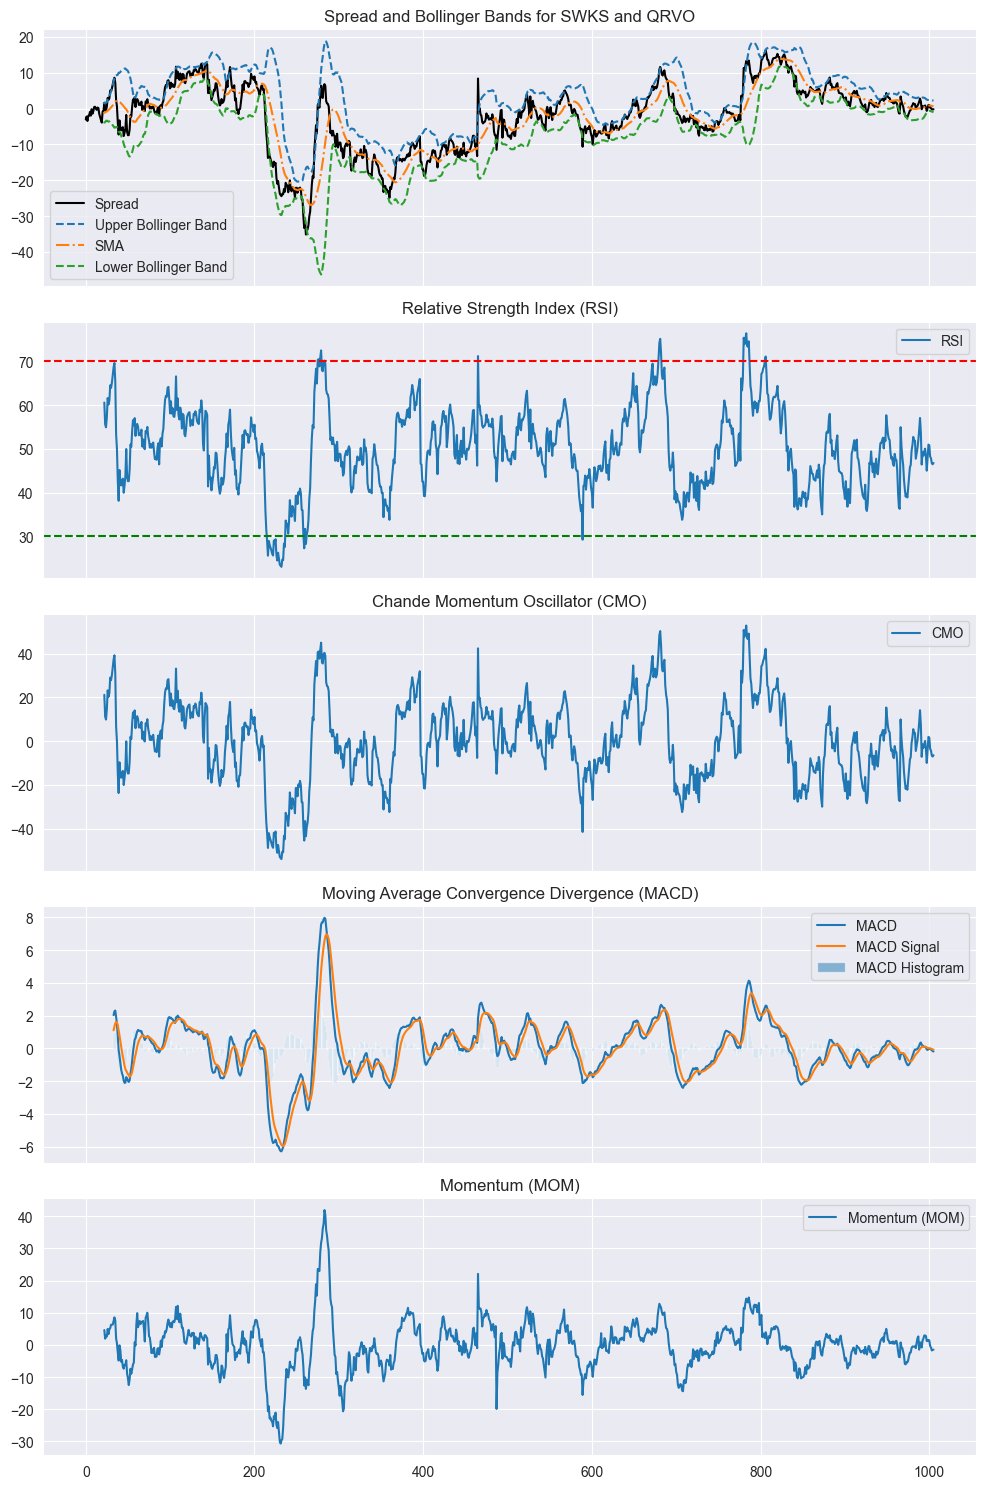

In [23]:
import matplotlib.pyplot as plt

def plot_spread_and_indicators(pair, spread, indicators):
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15), sharex=True)

    axes[0].plot(spread, label='Spread', color='black')
    axes[0].plot(indicators['Upper_BB'], label='Upper Bollinger Band', linestyle='--')
    axes[0].plot(indicators['Middle_BB'], label='SMA', linestyle='-.')
    axes[0].plot(indicators['Lower_BB'], label='Lower Bollinger Band', linestyle='--')
    axes[0].set_title(f'Spread and Bollinger Bands for {pair[0]} and {pair[1]}')
    axes[0].legend()

    # Plotting RSI
    axes[1].plot(indicators['RSI'], label='RSI')
    axes[1].axhline(70, color='red', linestyle='--') # Overbought line
    axes[1].axhline(30, color='green', linestyle='--') # Oversold line
    axes[1].set_title('Relative Strength Index (RSI)')
    axes[1].legend()

    # Plotting CMO
    axes[2].plot(indicators['CMO'], label='CMO')
    axes[2].set_title('Chande Momentum Oscillator (CMO)')
    axes[2].legend()

    # Plotting MACD
    axes[3].plot(indicators['MACD'], label='MACD')
    axes[3].plot(indicators['MACD_signal'], label='MACD Signal')
    axes[3].bar(indicators.index, indicators['MACD_hist'], label='MACD Histogram', alpha=0.5)
    axes[3].set_title('Moving Average Convergence Divergence (MACD)')
    axes[3].legend()

    # Plotting MOM
    axes[4].plot(indicators['MOM'], label='Momentum (MOM)')
    axes[4].set_title('Momentum (MOM)')
    axes[4].legend()

    plt.tight_layout()
    plt.show()

# Example usage
pair_to_visualize = selected_pairs[0]
spread = data[pair_to_visualize[0]] - data[pair_to_visualize[1]]
indicators = spreads_with_indicators[pair_to_visualize]

plot_spread_and_indicators(pair_to_visualize, spread, indicators)


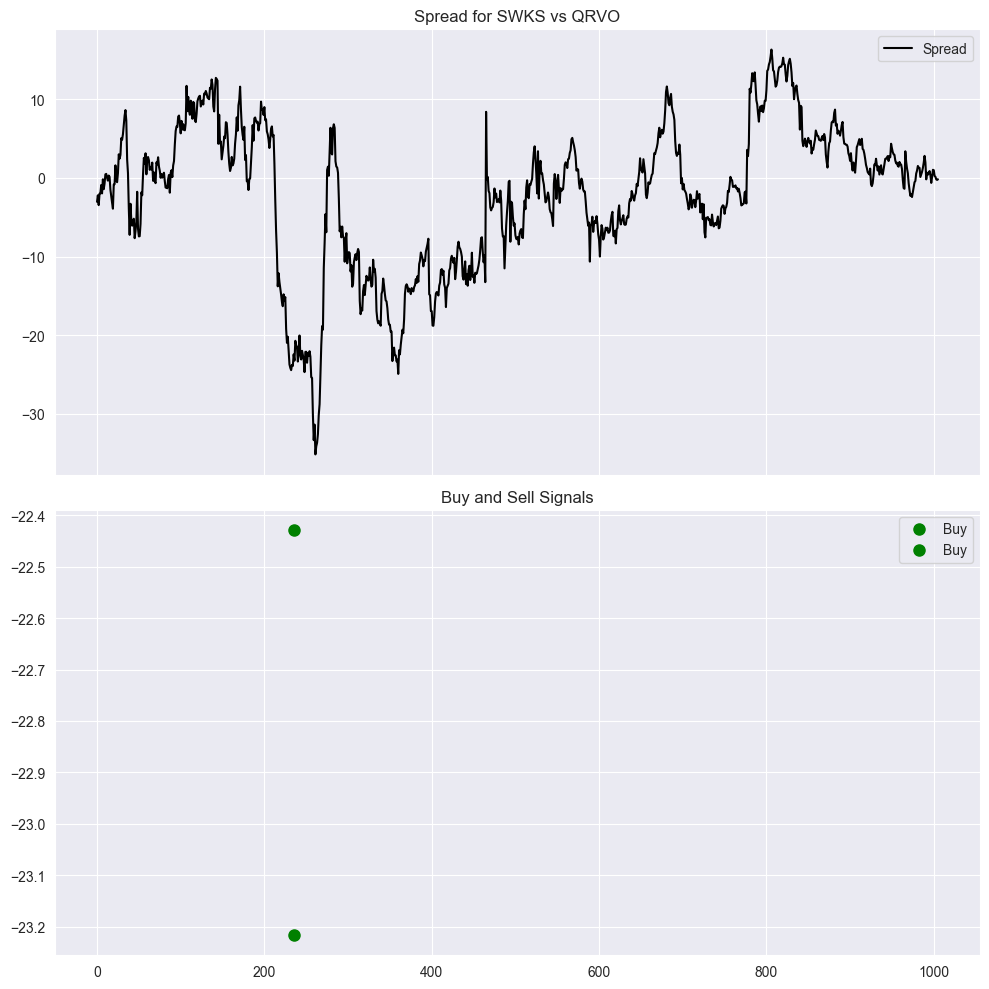

In [24]:
def calculate_signals(indicators, rsi_buy_threshold=30, rsi_sell_threshold=70, macd_buy_signal='Bullish', macd_sell_signal='Bearish'):
    signals = []
    in_position = False

    for i in range(len(indicators)):
        rsi_value = indicators['RSI'].iloc[i]
        macd_signal_value = indicators['MACD'].iloc[i] - indicators['MACD_signal'].iloc[i]

        if rsi_value < rsi_buy_threshold and macd_signal_value > 0:
            signal = 'Buy'
            in_position = True
        elif rsi_value > rsi_sell_threshold and macd_signal_value < 0:
            signal = 'Sell'
            in_position = False
        else:
            if in_position:
                signal = 'Hold'
            else:
                signal = 'No Position'

        signals.append(signal)

    return signals

# Visualize spread and signals for the first pair (you can loop through all pairs)
pair_to_visualize = selected_pairs[0]
spread_to_visualize = selected_data[pair_to_visualize[0]] - selected_data[pair_to_visualize[1]]
indicators_to_visualize = spreads_with_indicators[pair_to_visualize]
signals_to_visualize = calculate_signals(indicators_to_visualize)

# Plotting spread and signals
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)
axes[0].plot(spread_to_visualize, label='Spread', color='black')
axes[0].set_title(f'Spread for {pair_to_visualize[0]} vs {pair_to_visualize[1]}')
axes[0].legend()

# Plot buy and sell signals
for i in range(len(signals_to_visualize)):
    if signals_to_visualize[i] == 'Buy':
        axes[1].plot(i, spread_to_visualize.iloc[i], 'go', markersize=8, label='Buy')
    elif signals_to_visualize[i] == 'Sell':
        axes[1].plot(i, spread_to_visualize.iloc[i], 'ro', markersize=8, label='Sell')

axes[1].set_title('Buy and Sell Signals')
axes[1].legend()

plt.tight_layout()
plt.show()